<a href="https://colab.research.google.com/github/oraziotorre/TTinsight/blob/main/TTinsight_ModelDevelopment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TTinsight


---


## Model Development


### Inizializzazione

In [137]:
# Gestione dei dati
import pandas as pd
import numpy as np
from collections import Counter
import ast
import math

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning e metriche
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    log_loss,
    f1_score,
)

# Deep Learning con Keras e TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Dense,
    Concatenate,
    Masking,
    Embedding,
    Dropout,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.sequence import pad_sequences


In [138]:
dataset = pd.read_csv("cleaned_dataset.csv")

dataset

,players_gender_M,players_gender_W,players_gender_X,is_final,final_set,opponent_final_set,player_points,set_result
0,0,1,0,1,0,0,"[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...",0
1,0,1,0,1,0,0,"[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...",1
2,0,1,0,1,0,0,"[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...",1
3,0,1,0,1,0,0,"[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...",0
4,0,1,0,1,0,0,"[1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 6, 7, ...",1
...,...,...,...,...,...,...,...,...
139203,1,0,0,0,0,0,"[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, ...",1
139204,1,0,0,0,0,1,"[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...",1
139205,1,0,0,0,1,0,"[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...",0
139206,1,0,0,0,1,1,"[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6]",0


### Funzioni di supporto

**DECIDERE COSA FARE:
TOGLIERLI DIRETTAMENTE NEL DATAPREPROCESSING
OPPURE TENERLI E USARE UNA TECNICA AGGIUNTIVA**


Le prestazioni del modello calano se manteniamo le situazioni in cui si arriva
ai vantaggi 10-10

 **Non considerariamo i casi di 10-10 e parità a salire**.

 Questo aiuta a ridurre la **complessità e la variabilità del modello**, migliorando la sua capacità di generalizzare su dati più comuni e rilevanti.

 Questi casi rari influiscono l'efficacia del modello, in quanto aumentano il rischio di overfitting e introducono rumore nei dati.

In [139]:
import pandas as pd
import ast  # Per convertire una stringa in lista

def remove_rows_with_large_player_points(df):
    # Funzione che verifica la lunghezza della lista
    def check_length(player_points):
        try:
            # Se player_points è una stringa, proviamo a convertirla in una lista
            if isinstance(player_points, str):
                player_points = ast.literal_eval(player_points)
            # Verifica la lunghezza della lista
            return len(player_points) <= 20
        except:
            # In caso di errore (es. dati non validi), consideriamo la riga come valida
            return True

    # Filtra le righe in base alla lunghezza della lista
    df_filtered = df[df['player_points'].apply(check_length)]
    return df_filtered

dataset = remove_rows_with_large_player_points(dataset)
dataset

,players_gender_M,players_gender_W,players_gender_X,is_final,final_set,opponent_final_set,player_points,set_result
0,0,1,0,1,0,0,"[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...",0
1,0,1,0,1,0,0,"[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...",1
2,0,1,0,1,0,0,"[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...",1
3,0,1,0,1,0,0,"[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...",0
4,0,1,0,1,0,0,"[1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 6, 7, ...",1
...,...,...,...,...,...,...,...,...
139203,1,0,0,0,0,0,"[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, ...",1
139204,1,0,0,0,0,1,"[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...",1
139205,1,0,0,0,1,0,"[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...",0
139206,1,0,0,0,1,1,"[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6]",0


In [140]:
import ast

def generate_score_sequence(player_points):
    # Se player_points è vuoto o non valido, restituiamo una lista vuota (evitando righe nulle)
    if not player_points:
        return []

    # Se player_points è una stringa che sembra una lista, la convertiamo in una lista effettiva
    if isinstance(player_points, str):
        try:
            player_points = ast.literal_eval(player_points)  # Converte la stringa in una lista
        except (ValueError, SyntaxError):
            return []  # Se non è una lista valida, ritorniamo una lista vuota

    # Verifica che player_points sia effettivamente una lista di numeri
    if isinstance(player_points, list):
        try:
            # Converte i valori in interi se sono numeri come stringhe
            player_points = [int(x) for x in player_points]
        except ValueError:
            return []  # Se ci sono errori di conversione, ritorniamo una lista vuota

    # Crea una sequenza delle liste
    sequence = [list(player_points[:i]) for i in range(1, len(player_points) + 1)]
    return sequence

# Generiamo e esplodiamo la colonna
dataset['player_points'] = dataset['player_points'].apply(generate_score_sequence)


# Esplodiamo la colonna 'player_points'
dataset = dataset.explode('player_points', ignore_index=True)

dataset


<ipython-input-140-f8f7170de5d0>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['player_points'] = dataset['player_points'].apply(generate_score_sequence)


,players_gender_M,players_gender_W,players_gender_X,is_final,final_set,opponent_final_set,player_points,set_result
0,0,1,0,1,0,0,[0],0
1,0,1,0,1,0,0,"[0, 0]",0
2,0,1,0,1,0,0,"[0, 0, 1]",0
3,0,1,0,1,0,0,"[0, 0, 1, 2]",0
4,0,1,0,1,0,0,"[0, 0, 1, 2, 2]",0
...,...,...,...,...,...,...,...,...
1943365,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7]",1
1943366,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8]",1
1943367,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9]",1
1943368,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9]",1


In [141]:
# Funzione per calcolare le caratteristiche
def calculate_features(player_points):
    sum_values = sum(player_points)  # Somma dei valori
    num_values = len(player_points)  # Lunghezza (numero totale di valori)

    # Calcolo duplicati (numero di valori che appaiono più di una volta)
    if player_points[0] == 0:
      num_duplicates = 1 + sum(count - 1 for count in Counter(player_points).values() if count > 1)
    else:
      num_duplicates = sum(count - 1 for count in Counter(player_points).values() if count > 1)

    # Calcolo entropia
    entropy = -sum((count / num_values) * math.log2(count / num_values) for count in Counter(player_points).values() if count > 0)

    return num_values, num_duplicates, entropy, sum_values

# Funzione per applicare i calcoli al DataFrame
def process_dataset(dataset):
    num_values_list = []
    num_duplicates_list = []
    entropy_list = []
    sum_list = []

    # Ciclo per ogni lista di player_points nel dataset
    for player_points in dataset['player_points']:
      if isinstance(player_points, list):
        num_values, num_duplicates, entropy, sum_values = calculate_features(player_points)
        num_values_list.append(num_values)
        num_duplicates_list.append(num_duplicates)
        entropy_list.append(entropy)
        sum_list.append(sum_values)

    # Aggiungiamo i risultati al dataset
    dataset['num_values'] = num_values_list
    dataset['num_duplicates'] = num_duplicates_list
    dataset['entropy'] = entropy_list
    dataset['sum_values'] = sum_list

    return dataset

# Applicazione del calcolo al DataFrame
dataset = process_dataset(dataset)

# Riorganizzare le colonne per posizionarle dopo player_points
player_points_index = dataset.columns.get_loc('player_points')

# Inseriamo le nuove colonne subito dopo 'player_points'
dataset.insert(player_points_index + 1, 'num_values',  dataset.pop('num_values'))
dataset.insert(player_points_index + 2, 'num_duplicates', dataset.pop('num_duplicates'))
dataset.insert(player_points_index + 3, 'entropy', dataset.pop('entropy'))
dataset.insert(player_points_index + 4, 'sum_values',  dataset.pop('sum_values'))

# Mostra il DataFrame risultante
dataset

,players_gender_M,players_gender_W,players_gender_X,is_final,final_set,opponent_final_set,player_points,num_values,num_duplicates,entropy,sum_values,set_result
0,0,1,0,1,0,0,[0],1,1,-0.000000,0,0
1,0,1,0,1,0,0,"[0, 0]",2,2,-0.000000,0,0
2,0,1,0,1,0,0,"[0, 0, 1]",3,2,0.918296,1,0
3,0,1,0,1,0,0,"[0, 0, 1, 2]",4,2,1.500000,3,0
4,0,1,0,1,0,0,"[0, 0, 1, 2, 2]",5,3,1.521928,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1943365,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7]",12,5,2.855389,43,1
1943366,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8]",13,5,3.026987,51,1
1943367,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9]",14,5,3.182006,60,1
1943368,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9]",15,6,3.189898,69,1


Per LSTM.
Effettuiamo una trasformazione del player_points in un formato binario per migliorare le prestazioni del modello

L'idea è di rappresentare ogni punto del gioco come un cambiamento rispetto al punto precedente.
**Utilizzando 1 e 0**, il modello può catturare se un giocatore ha guadagnato o meno il punto rispetto al precedente.
Questo permette alla rete neurale di **concentrarsi sul cambiamento tra i punti (vittoria o perdita di un punto)**, piuttosto che sui valori assoluti dei punteggi.
La rete dovrà capire come evolvono i punteggi (vittorie e sconfitte nei punti), non necessariamente il punteggio esatto.

In [142]:
'''
Trasformazione dei set in sequenze di 1 e 0
'''

# Converte i numeri in un altro formato
def transform_player_points(points):
    transformed = []

    for i in range(len(points)):
        points[i] = int(points[i])  # Conversione del punteggio in int per evitare problemi di tipo

        # Per il primo punteggio, aggiungiamo 1 se il punteggio è maggiore di 0, altrimenti 0
        if i == 0:
            transformed.append(1 if points[i] > 0 else 0)
        else:
            # Aggiungiamo 1 se il punteggio è maggiore del precedente, altrimenti 0
            transformed.append(1 if points[i] > points[i - 1] else 0)

    return transformed

dataset['player_points'] = dataset['player_points'].apply(transform_player_points)

# Visualizza il dataframe risultante per verificare le trasformazioni applicate
dataset


,players_gender_M,players_gender_W,players_gender_X,is_final,final_set,opponent_final_set,player_points,num_values,num_duplicates,entropy,sum_values,set_result
0,0,1,0,1,0,0,[0],1,1,-0.000000,0,0
1,0,1,0,1,0,0,"[0, 0]",2,2,-0.000000,0,0
2,0,1,0,1,0,0,"[0, 0, 1]",3,2,0.918296,1,0
3,0,1,0,1,0,0,"[0, 0, 1, 1]",4,2,1.500000,3,0
4,0,1,0,1,0,0,"[0, 0, 1, 1, 0]",5,3,1.521928,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1943365,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]",12,5,2.855389,43,1
1943366,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1]",13,5,3.026987,51,1
1943367,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]",14,5,3.182006,60,1
1943368,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0]",15,6,3.189898,69,1


### Logistic Regression

In [143]:
X = np.array((dataset[['players_gender_M'	,'players_gender_W',	'players_gender_X','is_final', 'final_set', 'opponent_final_set','num_values', 'num_duplicates', 'entropy', 'sum_values']].values))

#X = np.array((dataset[['num_values', 'num_duplicates', 'entropy', 'sum_values']].values))

Y = np.array(dataset['set_result'].values)  # Target binari

# Test-Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [144]:
logreg_model_ts = LogisticRegression(max_iter=1000, random_state=42)

# Addestramento
history_logreg_ts = logreg_model_ts.fit(X_train, Y_train)

# Predizioni
Y_pred_ts = logreg_model_ts.predict(X_test)
Y_pred_prob_ts = logreg_model_ts.predict_proba(X_test)

# Calcolo della curva ROC
fpr_ts, tpr_ts, _ = roc_curve(Y_test, Y_pred_prob_ts[:, 1])
roc_auc_ts = auc(fpr_ts, tpr_ts)

# Valutazione
accuracy_ts = accuracy_score(Y_test, Y_pred_ts)
log_loss_ts = log_loss(Y_test, Y_pred_prob_ts)

print(f"Accuratezza Test-Split: {accuracy_ts:.2f}")
print(f"AUC Test-Split: {roc_auc_ts:.2f}")
print(f"Log Loss Test-Split: {log_loss_ts:.2f}")
print(classification_report(Y_test, Y_pred_ts))

Accuratezza Test-Split: 0.79
AUC Test-Split: 0.88
Log Loss Test-Split: 0.44
              precision    recall  f1-score   support

           0       0.79      0.79      0.79    194959
           1       0.79      0.79      0.79    193715

    accuracy                           0.79    388674
   macro avg       0.79      0.79      0.79    388674
weighted avg       0.79      0.79      0.79    388674



In [145]:
'''
test case personalizzati
'''

test_seq = np.array([[1,1,1,1,1,2,3,4,5,6],
                     [0,1,2,3,4,5,5,5,5,6],
                     [1,2,3,4,5,6,6,6,6,6],
                     [0,0,0,0,1,2,3,4,5,6]])  # Punti del giocatore

# Calcolo delle feature
def calculate_features(player_points):
    sum_values = sum(player_points)  # Somma dei valori
    num_values = len(player_points)  # Lunghezza (numero totale di valori)
    if player_points[0] == 0:
        num_duplicates = 1 + sum(count - 1 for count in Counter(player_points).values() if count > 1)
    else:
        num_duplicates = sum(count - 1 for count in Counter(player_points).values() if count > 1)
    entropy = -sum((count / num_values) * math.log2(count / num_values) for count in Counter(player_points).values() if count > 0)
    return num_values, num_duplicates, entropy, sum_values

num_values_list = []
num_duplicates_list = []
entropy_list = []
sum_values_list = []

for seq in test_seq:
    num_values, num_duplicates, entropy, sum_values = calculate_features(seq)
    num_values_list.append(num_values)
    num_duplicates_list.append(num_duplicates)
    entropy_list.append(entropy)
    sum_values_list.append(sum_values)

# Creare un nuovo array con i valori calcolati
test_seq_updated = np.array([num_values_list, num_duplicates_list, entropy_list, sum_values_list]).T

# Aggiungere eventuali feature aggiuntive
extra_values = np.array([[1, 0, 0, 0, 0, 0]] * test_seq_updated.shape[0])
test_seq_updated = np.hstack((extra_values, test_seq_updated))

In [146]:
'''
Il modello non riesce a generalizzare considerando le intere sequenze,
per questo motivo abbiamo deciso di considerare come feature di addestramento
il numero di valori, la somma, il numero di duplicati e l'entropia applicate
su tutte le istanze dei vari set(le sequenze)

In questo modo il modello riesce a predire bene casi semplici
ma non riesce a generalizzare casi più complessi come rimonte intermedie

Inoltre abbiamo notato che l'aggiunta delle feature relative alla tipologia
di set peggiorano in molti casi le prestazioni del modello, questo perchè
ci sono molte combinazioni di queste feature rare. Per esempio un set finale
di una finale di torneo giocata da un gender X
'''

# Concatenare le due parti per formare il caso di test finale
#X_test_case_concate = [np.concatenate([x_bin, seq]) for x_bin, seq in zip(test_bin, test_seq)]
#X_test_case = np.array(X_test_case_concate)

X_test_case = test_seq_updated

# Predizioni per il modello Test-Split
probabilities_ts = logreg_model_ts.predict_proba(X_test_case)
prob_class_1_ts = probabilities_ts[2][1]
prob_class_0_ts = probabilities_ts[2][0]

print(f"Probabilità di vincere (classe 1) Test-Split: {prob_class_1_ts:.4f}")
print(f"Probabilità di perdere (classe 0) Test-Split: {prob_class_0_ts:.4f}")

Probabilità di vincere (classe 1) Test-Split: 0.8294
Probabilità di perdere (classe 0) Test-Split: 0.1706


#### Cross validation

In [147]:
X = np.array((dataset[['players_gender_M'	,'players_gender_W',	'players_gender_X','is_final', 'final_set', 'opponent_final_set','num_values', 'num_duplicates', 'entropy', 'sum_values']].values))

#X = np.array((dataset[['num_values', 'num_duplicates', 'entropy', 'sum_values']].values))

Y = np.array(dataset['set_result'].values)  # Target binari

# K-Fold Cross Validation
logreg_model_kf = LogisticRegression(max_iter=1000, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies_kf = []
classification_reports_kf = []
roc_auc_kf = []
log_losses_kf = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Addestramento
    logreg_model_kf.fit(X_train, Y_train)

    # Predizioni
    Y_pred = logreg_model_kf.predict(X_test)
    Y_pred_prob = logreg_model_kf.predict_proba(X_test)

    # Valutazione
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies_kf.append(accuracy)
    classification_reports_kf.append(classification_report(Y_test, Y_pred))

    # ROC Curve e AUC
    fpr_kf, tpr_kf, _ = roc_curve(Y_test, Y_pred_prob[:, 1])
    roc_auc = auc(fpr_kf, tpr_kf)
    roc_auc_kf.append(roc_auc)

    # Log Loss
    log_loss_value = log_loss(Y_test, Y_pred_prob)
    log_losses_kf.append(log_loss_value)

# Media delle performance
mean_accuracy_kf = np.mean(accuracies_kf)
mean_roc_auc_kf = np.mean(roc_auc_kf)
mean_log_loss_kf = np.mean(log_losses_kf)

print(f"Accuratezza media K-Fold: {mean_accuracy_kf:.2f}")
print(f"AUC media K-Fold: {mean_roc_auc_kf:.2f}")
print(f"Log Loss medio K-Fold: {mean_log_loss_kf:.2f}")

Accuratezza media K-Fold: 0.79
AUC media K-Fold: 0.88
Log Loss medio K-Fold: 0.44


### Random Forest

In [ ]:
X = np.array((dataset[['players_gender_M'	,'players_gender_W',	'players_gender_X','is_final', 'final_set', 'opponent_final_set']].values))

Y = np.array(dataset['set_result'].values)  # Target binari

# Crea il modello di Random Forest
rf = RandomForestClassifier(random_state=42)

# Variabili per raccogliere i risultati
feature_importances = []

# Divisione train-test (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

rf.fit(X_train, Y_train)

# Nomi delle feature
feature_names = ['players_gender_M', 'players_gender_W', 'players_gender_X', 'is_final',
                 'final_set', 'opponent_final_set']


# Estrai le feature importance per ogni albero
tree_importances = np.array([tree.feature_importances_ for tree in rf.estimators_])

# Calcola la media e la deviazione standard per ogni feature
mean_importances = tree_importances.mean(axis=0)
std_importances = tree_importances.std(axis=0)

In [ ]:
# Grafico con barre e barre d'errore
plt.figure(figsize=(6, 6))
plt.bar(feature_names, mean_importances, yerr=std_importances, color="green", alpha=1, capsize=5)
plt.title("Feature Importances")
plt.ylabel("Mean decrease in impurity")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
'''
vedo l'importanza di ciascun punto per ogni tipologia di set
11-0 , 11-1,.....,11-9

DECIDI SE CANCELLARLO E CONSIDERARE SOLO LE FEATURE USATE NEL LOGISTIC REGRESSION
'''


# Paddiamo tutte le sequenze di player_points in anticipo
player_points_padded = pad_sequences(dataset['player_points'], padding='post', truncating='post', value=-1)

# Utilizziamo solo player_points come feature, senza altre colonne
X = player_points_padded

# Target binario Y
Y = np.array(dataset['set_result'].values)

# Creiamo il modello di Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Itera su ogni possibile lunghezza di player_points da 10 a 19
for length in range(10, 20):
    # Filtra il dataset per includere solo i dati con player_points di lunghezza 'length'

    indices = np.where([len(points) == length for points in dataset['player_points']])[0]

    # Seleziona X e Y per gli indici selezionati
    X_subset = X[indices]
    Y_subset = Y[indices]

    # Suddividi il dataset in train-test (80% train, 20% test)
    X_train, X_test, Y_train, Y_test = train_test_split(X_subset, Y_subset, test_size=0.2, random_state=42, stratify=Y_subset)

    # Allena il modello sui dati di addestramento
    rf_model.fit(X_train, Y_train)

    # Estrai l'importanza delle feature per questo modello
    importances = rf_model.feature_importances_

    importances_trimmed = importances[:length]
    print(len(importances_trimmed))
    # Nomi delle feature (solo player_point_1, player_point_2, ..., player_point_19)
    feature_names = [f'player_point_{i}' for i in range(1, length+1)]


    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances_trimmed, y=feature_names, palette="viridis")
    plt.title("Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

### SVM

### LSTM

 **LSTM** (Long Short-Term Memory), un tipo di rete neurale ricorrente è il modello che abbiamo deciso di utilizzare per effettuare previsioni sulle vittorie del set o meno.
 - LSTM può imparare come i punteggi cambiano in **base alle azioni precedenti**, ovvero, consentono di prevedere il risultato finale della partita basato **sull'andamento dei punteggi** (rimonta o stallo) durante il set.
 - Le variabili "is_final", "final_set", "opponent_final_set", permettono di integrare queste variabili temporali in modo che il modello non solo predica un punteggio finale, ma può anche tener conto di eventi come **"l'ultimo set"** o **"l'avversario in difficoltà"**.

 E' possibile migliorare questo modello per facilitarlo successivamente

In [ ]:
# Verifichiamo che 'player_points' sia una lista di interi
player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)  # Target binari

X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(player_points, set_result, test_size=0.2, random_state=42, stratify=set_result)


# Effettuiamo il padding per le sequenze di training e test
X_train = pad_sequences(X_train_raw, maxlen=19, padding='post', truncating='post', value=-1)
X_test = pad_sequences(X_test_raw, maxlen=19, padding='post', truncating='post', value=-1)

# Reshape del target
Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)


# Creazione del modello
'''
Abbiamo convertito le sequenze di interi in sequenze binarie.
Questo perchè i valori non ci interessano ci interessano solo
la sequenza temporale dei punteggi

INFINE AGGIUNGERE ANCHE LE ALTRE FEATURE

Esperimenti con lunghezza di sequenza massima 19, 128 batch, 3 epoche e con tutte le combinazioni
L'attuale modello sembra dare predizioni veritiere
si noti il caso 1,1,1,1,0,0,0,0 prob. di vincere di 0.5284746
invece il caso 0,0,0,0,1,1,1,1 prob. di vincere di 0.4808944

Analizzare meglio le prestazioni dei diversi modelli

Ho analizzato le prestazioni con learning rate differenti
e non ho notato grandi differenze. Con n learning rate di
0.0001 rispetto a 0.001
si noti il caso 1,1,1,1,0,0,0,0 prob. di vincere di 0.50075436
invece il caso 0,0,0,0,1,1,1,1 prob. di vincere di 0.48774242
sembra penalizza maggiormente quando si subisce un recupero
'''

model = Sequential([
    Embedding(input_dim=3, output_dim=32),
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=False),
    Dropout(0.3),  # Probabilità di disattivare un nodo
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilazione del modello
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Allenamento del modello
history = model.fit(X_train, Y_train, epochs=5, batch_size=128)

In [ ]:
# Testing del modello
Y_pred = model.predict(X_test)
Y_pred_binary = (Y_pred > 0.5).astype(int)  # Converte le probabilità in valori binari

# Calcolo delle metriche di performance
print("Accuracy:", accuracy_score(Y_test, Y_pred_binary))
print("Classification Report:\n", classification_report(Y_test, Y_pred_binary))

In [ ]:
# Previsione
test_sequences = [[1,1,1,1,1,1,1,1,0,0,0,0],
                  [1,0,1,0,1,0,1,1,0,1,1,1]]
padded_test_sequences = pad_sequences(
    test_sequences,
    maxlen = 19,
    padding ='post',
    truncating ='post',
    value = -1
)

probabilità = model.predict(padded_test_sequences)

# La probabilità per la classe 1 (output di sigmoid)
print(probabilità[1][0])

In [ ]:
'''
Test LSTM con tutte le feature
'''

player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)
global_features = np.array(dataset[['players_gender_M', 'players_gender_W', 'players_gender_X', 'is_final', 'final_set', 'opponent_final_set']])

# Padding delle sequenze
max_sequence_length = 19  # Impostato come precedentemente
player_points_padded = pad_sequences(player_points, maxlen=max_sequence_length, padding='post', truncating='post', value=-1)

# Train/Test Split (80/20)
X_train_seq, X_test_seq, Y_train, Y_test, X_train_global, X_test_global = train_test_split(
    player_points_padded, set_result, global_features, test_size=0.2, random_state=42, stratify=set_result
)


# Input per sequenze
sequence_input = Input(shape=(max_sequence_length,), name='sequence_input')

# Embedding con 3 possibili valori di input (es. 0, 1, -1) e vettori di dimensione 32.
x = Embedding(input_dim=3, output_dim=32)(sequence_input)

# Primo strato LSTM con 64 unità, che restituisce l'intera sequenza.
x = LSTM(64, return_sequences=True)(x)

# Secondo strato LSTM con 32 unità, che restituisce solo l'ultimo stato.
x = LSTM(32, return_sequences=False)(x)

# Input per feature globali
global_input = Input(shape=(6,), name='global_input')
global_dense = Dense(16, activation='relu')(global_input)

# Combina i due input
combined = concatenate([x, global_dense])
x = Dropout(0.3)(combined) # Aggiungiamo dropout per ridurre l'overfitting
x = Dense(32, activation='relu')(x) # Strato denso con 32 unità per la combinazione.
output = Dense(1, activation='sigmoid')(x)

# Costruisci il modello
lstm_model = Model(inputs=[sequence_input, global_input], outputs=output)

# Compila il modello
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Allenamento del modello LSTM
history_lstm = lstm_model.fit([X_train_seq, X_train_global], Y_train, epochs=5, batch_size=128)

# Valutazione del modello LSTM
loss_lstm, accuracy_lstm = lstm_model.evaluate([X_test_seq, X_test_global], Y_test, verbose=0)
Y_pred_lstm = lstm_model.predict([X_test_seq, X_test_global])

# Stampa dei risultati
print(f"LSTM - Test Loss: {loss_lstm:.4f}")
print(f"LSTM - Test Accuracy: {accuracy_lstm:.4f}")


In [ ]:
'''
MIGLIORARE I PARAMETRI DELL' LSTM, come qui


# Assicurati che 'player_points' sia una lista di interi
player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)  # Target binari

X_train, X_val, Y_train, Y_val = train_test_split(player_points, set_result, test_size=0.2, random_state=42)
X_train = pad_sequences(X_train, maxlen=19, padding='post', truncating='post', value=-1)
X_val = pad_sequences(X_val, maxlen=19, padding='post', truncating='post', value=-1)

# Reshape del target
Y_train = Y_train.reshape(-1, 1)
Y_val = Y_val.reshape(-1, 1)

model = Sequential([
    Embedding(input_dim=2, output_dim=64),  # Embedding layer (2 valori, 64 neuroni)
    LSTM(128, return_sequences=False),  # LSTM con 128 neuroni
    Dropout(0.5),  # Aggiungi Dropout per evitare overfitting
    Dense(64, activation='relu'),  # Aggiungi un layer Dense intermedio
    Dense(1, activation='sigmoid')  # Output layer per la classificazione binaria
])

# Compilazione del modello
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_val, Y_val), callbacks=[early_stopping])
'''

### Performance Analysis

In [ ]:
# ANALISI DELLA CORRELAZIONE LINEARE DELLE FEATURE
dataset.drop('player_points', axis=1, inplace=True)

corr = dataset.corr()
plt.figure(figsize=(10, 8))  # Aumenta le dimensioni del grafico
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 10}, cbar=True)

# Ruotare le etichette delle colonne per evitare sovrapposizioni
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Mostrare il grafico
plt.tight_layout()  # Regola il layout per evitare sovrapposizioni
plt.show()

#Notiamo che i valori calcoli hanno una relazione lineare

In [ ]:
#ANALISI DELLA PROGRESSIONE DI APPRENDIMENTO del LOGISTIC REGRESSION


X_train_full, X_test, y_train_full, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Lista di dimensioni del training set
training_sizes = np.linspace(10, 400, 10, dtype=int)

# Per salvare gli F1-score
f1_scores = []

# Modello
model = LogisticRegression(max_iter=1000, random_state=42)

# Loop per addestrare il modello su set di training di dimensioni crescenti
for size in training_sizes:
    # Campioni di training ridotti
    X_train_subset = X_train_full[:size]
    y_train_subset = y_train_full[:size]

    # Addestramento del modello
    model.fit(X_train_subset, y_train_subset)

    # Predizione sul set di test
    y_pred = model.predict(X_test)

    # Calcola l'F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)


# Grafico del cambiamento dell'F1-score
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, f1_scores, marker='o', linestyle='-', color='b', label='F1-score')

# Aggiungi i valori veri sull'asse X
plt.xticks(training_sizes, labels=[str(x) for x in training_sizes], rotation=45)

plt.xlabel('Numero di campioni di training')
plt.ylabel('F1-score (weighted)')
plt.title('Cambiamento dell\'F1-score rispetto ai campioni di training')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# ANALISI DELLE PRESTAZIONI IN BASE ALLA LUNGHEZZA DELLA SEQUENZA - LSTM

# Calcola le lunghezze originali delle sequenze
performance_by_length = {}

# Troviamo gli indici delle sequenze che hanno una lunghezza pari a quella corrente.
sequence_lengths = [len(seq) for seq in X_test_raw]

# Creiamo gruppi basati sulle lunghezze
for length in range(1, 21):  # Lunghezze da 1 a 20
    indices = [idx for idx, seq_length in enumerate(sequence_lengths) if seq_length == length]

    if indices:  # Evita gruppi vuoti
        X_subset = X_test[indices]
        Y_subset = Y_test[indices]
        Y_pred_subset = model.predict(X_subset)

        # Convertiamo le probabilità in valori binari (0 o 1) utilizzando una soglia di 0.5.
        Y_pred_binary_subset = (Y_pred_subset > 0.5).astype(int)

        # Calcoliamo l'accuratezza confrontando i target veri (Y_subset) con le predizioni binarie.
        accuracy = accuracy_score(Y_subset, Y_pred_binary_subset)

        # Salviamo l'accuratezza nel dizionario associandola alla lunghezza corrente.
        performance_by_length[f"{length}"] = accuracy


'''
oppure per il modello con tutte le feature

# Analisi delle prestazioni per lunghezza delle sequenze
performance_by_length = {}
sequence_lengths = [len(seq) for seq in X_test_seq]

# Itera per lunghezze di sequenza da 1 a 20
for length in range(1, 21):  # Lunghezze da 1 a 20
    indices = [idx for idx, seq_length in enumerate(sequence_lengths) if seq_length == length]

    if indices:  # Procedi solo se ci sono sequenze con quella lunghezza
        X_subset = np.array([X_test_seq[idx] for idx in indices])
        Y_subset = np.array([Y_test[idx] for idx in indices])
        X_global_subset = np.array([X_test_global[idx] for idx in indices])

        # Assicurati che le sequenze abbiano la lunghezza corretta (es. padding/truncating)
        X_subset_padded = pad_sequences(X_subset, maxlen=19, padding='post', truncating='post', value=-1)

        # Predici i risultati
        Y_pred_subset = lstm_model.predict([X_subset_padded, X_global_subset])
        Y_pred_binary_subset = (Y_pred_subset > 0.5).astype(int)

        # Calcola l'accuratezza
        accuracy = accuracy_score(Y_subset, Y_pred_binary_subset)
        performance_by_length[f"{length}"] = accuracy
'''

plt.figure(figsize=(8, 6))
# Aggiusta per visualizzare le lunghezze come numeri e l'accuratezza associata
lengths = list(range(1, 21))  # Lunghezze da 1 a 19

# Estraiamo le accuratezze corrispondenti alle lunghezze e se la lunghezza non è presente assegniamo 0
accuracies = [performance_by_length.get(str(length), 0) for length in lengths]

plt.bar(lengths, accuracies, color='skyblue')
plt.xlabel('Lunghezza delle sequenze')
plt.ylabel('Accuratezza')
plt.title('Prestazioni del modello in base alla lunghezza delle sequenze')
plt.xticks(lengths)  # Mostra tutte le lunghezze sull'asse x
plt.show()

In [ ]:
# Calcolo della curva ROC LSTM
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)

# Grafico ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'LSTM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Falso Positivo Rate')
plt.ylabel('Vero Positivo Rate')
plt.title('Curva ROC per LSTM')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Grafico diminuzione della loss durante le poche LSTM
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Curva di apprendimento per LSTM')
plt.legend()
plt.show()

# Grafico miglioramento dell'accuratezza durante le epoche LSTM
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuratezza durante il training per LSTM')
plt.legend()
plt.show()

In [ ]:
# Calcolo della matrice di confusione
cm = confusion_matrix(Y_test, Y_pred_binary)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non Vinto', 'Vinto'], yticklabels=['Non Vinto', 'Vinto'])
plt.title('Matrice di Confusione per LSTM')
plt.xlabel('Predizioni')
plt.ylabel('Verità Effettive')
plt.show()

In [ ]:
#LOGISTIC REGRESSION VS CROSSVALIDATED LOGISTIC REGRESSION


# Visualizzazione delle performance di Accuratezza
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.bar(['K-Fold', 'Test-Split'], [mean_accuracy_kf, accuracy_ts], color=['blue', 'green'])
plt.title('Confronto Accuratezza')
plt.ylabel('Accuratezza')

# Visualizzazione delle performance di AUC
plt.subplot(1, 3, 2)
plt.bar(['K-Fold', 'Test-Split'], [mean_roc_auc_kf, roc_auc_ts], color=['blue', 'green'])
plt.title('Confronto AUC')
plt.ylabel('AUC')

# Visualizzazione delle performance di Log Loss
plt.subplot(1, 3, 3)
plt.bar(['K-Fold', 'Test-Split'], [mean_log_loss_kf, log_loss_ts], color=['blue', 'green'])
plt.title('Confronto Log Loss')
plt.ylabel('Log Loss')

plt.tight_layout()
plt.show()

# ROC Curve per il confronto visivo
fpr_kf, tpr_kf, _ = roc_curve(Y_test, logreg_model_kf.predict_proba(X_test)[:, 1])
fpr_ts, tpr_ts, _ = roc_curve(Y_test, logreg_model_ts.predict_proba(X_test)[:, 1])

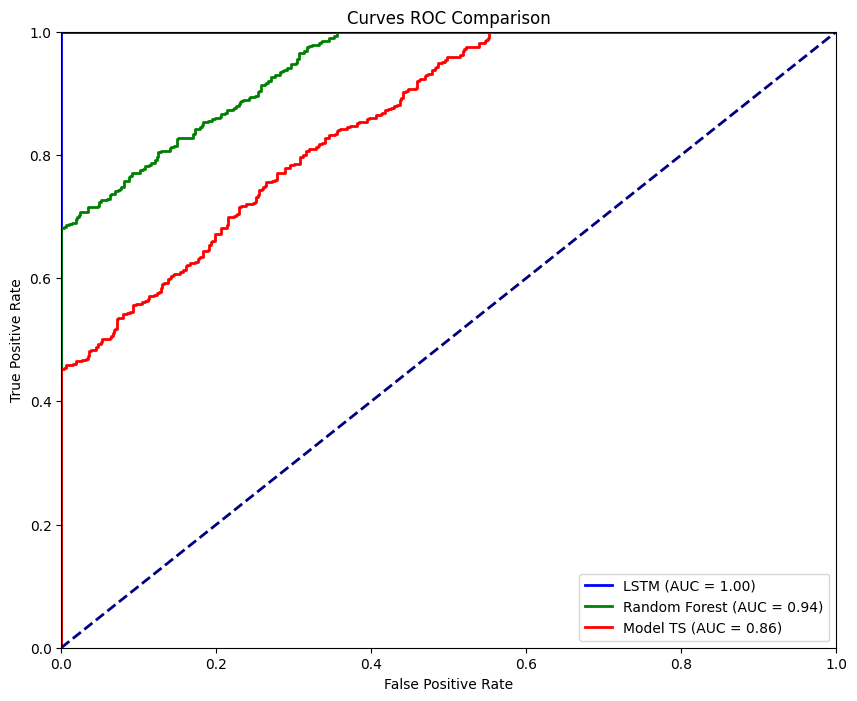

In [ ]:
# CONFRONTO DI ROC CURVE DI MODELLI DIFFERENTI

# Numero di campioni
n_samples = 1000

# Genera etichette vere (0 o 1) casuali
y_true = np.random.randint(0, 2, size=n_samples)


# MODIFICARE QUI, DOBBIAMO METTERE LE PRESTAZIONI VERE
# Genera probabilità predette per i tre modelli con una maggiore separazione tra le classi
# Per i modelli, facciamo in modo che le probabilità per la classe positiva siano abbastanza alte
y_pred_lstm = np.random.rand(n_samples) * 0.5 + (y_true == 1) * 0.5  # maggiore probabilità per classi positive
y_pred_rf = np.random.rand(n_samples) * 0.6 + (y_true == 1) * 0.4  # un po' di separazione maggiore
y_pred_ts = np.random.rand(n_samples) * 0.7 + (y_true == 1) * 0.3  # separazione simile

# Calcola le curve ROC per ogni modello
fpr_lstm, tpr_lstm, _ = roc_curve(y_true, y_pred_lstm)
fpr_rf, tpr_rf, _ = roc_curve(y_true, y_pred_rf)
fpr_ts, tpr_ts, _ = roc_curve(y_true, y_pred_ts)

# Calcola l'AUC per ogni modello
roc_auc_lstm = roc_auc_score(y_true, y_pred_lstm)
roc_auc_rf = roc_auc_score(y_true, y_pred_rf)
roc_auc_ts = roc_auc_score(y_true, y_pred_ts)

# Creazione del grafico
plt.figure(figsize=(10, 8))

# Aggiungi tutte le curve ROC al grafico
plt.plot(fpr_lstm, tpr_lstm, color='blue', lw=2, label=f'LSTM (AUC = {roc_auc_lstm:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_ts, tpr_ts, color='red', lw=2, label=f'Model TS (AUC = {roc_auc_ts:.2f})')

# Linea diagonale (linea di casualità)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Etichette e titolo
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curves ROC Comparison')
plt.legend(loc='lower right')

# Mostra il grafico
plt.show()

In [ ]:
# STATISTICHE PER RANDOM FOREST

# Calcolo della curva ROC

Y_pred = rf_model.predict(X_test)

fpr_rf, tpr_rf, _ = roc_curve(Y_test, Y_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Grafico ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Falso Positivo Rate')
plt.ylabel('Vero Positivo Rate')
plt.title('Curva ROC per RF')
plt.legend(loc='lower right')
plt.show()

# Convertiamo le predizioni in etichette binarie
Y_pred_binary = (Y_pred > 0.5).astype(int)

# Calcolo della matrice di confusione
cm = confusion_matrix(Y_test, Y_pred_binary)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non Vinto', 'Vinto'], yticklabels=['Non Vinto', 'Vinto'])
plt.title('Matrice di Confusione per RF')
plt.xlabel('Predizioni')
plt.ylabel('Verità Effettive')
plt.show()


In [ ]:
# ?

plt.figure(figsize=(8, 6))
plt.plot(fpr_kf, tpr_kf, color='blue', label=f'K-Fold (AUC = {mean_roc_auc_kf:.2f})')
plt.plot(fpr_ts, tpr_ts, color='green', label=f'Test-Split (AUC = {roc_auc_ts:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve: K-Fold vs Test-Split')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()